# DALL-E 학습 및 사용 예제
예제 학습을 위해서 약 9000개의 기하학적 도형들을 32x32 사이즈로 렌더링하고, 그 모양을 설명하는 자연어로 구성된 인공 데이터셋을 만듭시다. 예: small orange circle

DALL-E 가 배울 작업은 자연어 설명만 보고 기하학적인 이미지를 생성하는 것입니다.

모델의 일반화 성능을 가늠하기 위해, 오로지 30% 만큼의 데이터만 사용해서 학습하고 학습시에 제공하지 않은 자연어 설명으로부터 얼마나 기하학적 모양을 잘 생성하는지 확인해봅니다.

In [1]:
# check whether colab instance has GPU hardwear
!nvidia-smi

Fri Jul 29 16:52:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    10W /  N/A |    425MiB /  8192MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Fri Jul 29 16:52:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    11W /  N/A |    444MiB /  8192MiB |     27%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# install dalle-pytorch and restart the instance if necessary
!pip install dalle-pytorch


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


쉽게 도형 생성을 하기 위하여 [cairo](https://www.cairographics.org/) [라이브러리](https://pycairo.readthedocs.io/en/latest/)를 사용하여 봅시다.

In [4]:
!apt install libcairo2-dev
!pip install pycairo

'apt'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


dVAE와 Dall-e 모델은 [dalle-pytorch](https://github.com/lucidrains/DALLE-pytorch)를 사용해봅시다.

In [5]:
import math
import itertools
import os
import glob

import numpy as np
import cairo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from PIL import Image
from tqdm.autonotebook import tqdm, trange
import torch
from dalle_pytorch import DiscreteVAE, DALLE

# Dataset generation

In [6]:
rainbow_colors = ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]
rainbow_rgb = [np.array(mcolors.to_rgb(name)) * 255 for name in rainbow_colors]

def make_pic(size, shape_maker, color_name, scale, fill, ditherer, rotation):
    data = np.ones((size, size, 4), dtype=np.uint8)
    surface = cairo.ImageSurface.create_for_data(data, cairo.FORMAT_ARGB32, size, size)
    cr = cairo.Context(surface)
    cr.set_antialias(cairo.ANTIALIAS_NONE)
    cr.set_fill_rule(cairo.FILL_RULE_EVEN_ODD)
    
    cr.rectangle(0, 0, size, size)
    cr.set_source_rgb(1, 1, 1)
    cr.fill()
    cr.set_line_width(1 / (scale * size / 2))
    
    cr.translate(size // 2, size // 2)
    cr.scale(scale * size / 2, scale * size / 2)
    if color_name == "rainbow":
        cr.set_source_rgb(0, 0, 0)
    else:
        cr.set_source_rgb(*reversed(mcolors.to_rgb(color_name)))
        
    shape_maker(cr)
    if fill:
        cr.stroke_preserve()
        cr.fill()    
    else:
        cr.stroke()
        
    for _ in range(rotation):
        data = np.rot90(data)
        
    ditherer(data)
    
    if color_name == "rainbow":
        mask = data.sum(axis=2) != 255 * 4
        for r in range(size):
            data[r, mask[r, :], :3] = rainbow_rgb[r % len(rainbow_colors)]
        
    return data


Total shapes: 9216


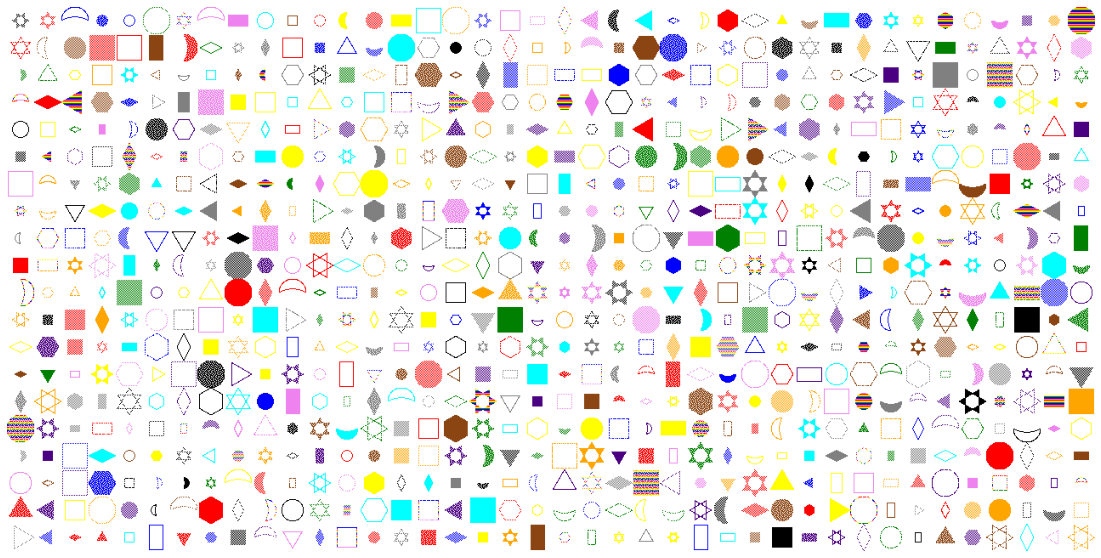

In [7]:
def circle_maker(cr):
    cr.arc(0, 0, 1, 0, 2 * math.pi)
    
    
def triangle_maker(cr):
    s3 = math.sqrt(3)
    cr.move_to(0, -1)
    cr.line_to(s3 / 2, 0.5)
    cr.line_to(-s3 / 2, 0.5)
    cr.line_to(0, -1)
    
    
def square_maker(cr):
    cr.rectangle(-0.9, -0.9, 1.8, 1.8)
    
def rectangle_maker(cr):
    cr.rectangle(-0.9, -0.5, 1.8, 1)    
    
def rhombus_maker(cr):
    cr.move_to(0, -1)
    cr.line_to(0.5, 0)
    cr.line_to(0, 1)
    cr.line_to(-0.5, 0)
    cr.line_to(0, -1)
    
    
def star_maker(cr):
    s3 = math.sqrt(3)
    cr.move_to(0, -1)
    cr.line_to(s3 / 2, 0.5)
    cr.line_to(-s3 / 2, 0.5)
    cr.line_to(0, -1)
    
    cr.move_to(0, 1)
    cr.line_to(s3 / 2, -0.5)
    cr.line_to(-s3 / 2, -0.5)
    cr.line_to(0, 1)
    
    
def hexagon_maker(cr):
    s3 = math.sqrt(3)
    cr.move_to(0, -1)
    cr.line_to(s3 / 2, -0.5)    
    cr.line_to(s3 / 2, 0.5)
    cr.line_to(0, 1)        
    cr.line_to(-s3 / 2, 0.5)
    cr.line_to(-s3 / 2, -0.5)    
    cr.line_to(0, -1)
    
    
def crescent_maker(cr):
    s3 = math.sqrt(3)    
    cr.arc(0, 0, 1, -math.pi * 0.5, math.pi * 0.5)
    cr.move_to(0, -1)
    cr.arc(-s3, 0, 2, -math.pi / 6, math.pi / 6)
   
    
def dither_solid(data):
    pass


def dither(img):
    for y in range(0, img.shape[0] - 1):
        for x in range(1, img.shape[1] - 1):
            pix = img[y][x]
            newpix = round(pix)

            error = pix - newpix

            img[y][x] = newpix

            img[y    , x + 1] += error * 7/16
            img[y + 1, x - 1] += error * 3/16
            img[y + 1, x    ] += error * 5/16
            img[y + 1, x + 1] += error * 1/16

def dither_halftone(data):
    mask = (data.astype(int).sum(axis=2) != 255 * 3).astype(float)
    mask *= 0.5
    dither(mask)
    data[mask > 0.5, :] = 255
        
def dither_shaded(data):
    mask = (data.astype(int).sum(axis=2) != 255 * 3).astype(float)
    mask *= 0.3
    dither(mask)
    data[mask > 0.5, :] = 255        

    
variations = {
    "scale": {"big": 1, "bigger": 0.8, "smaller": 0.6, "small": 0.4},
    "fill": {"filled": True, "": False},
    "ditherer": {"": dither_solid, "shaded": dither_shaded, "halftone": dither_halftone},
    "color_name": {c: c for c in rainbow_colors + ["cyan", "saddlebrown", "black", "gray", "rainbow"]},
    "shape_maker": {"circle": circle_maker, "triangle": triangle_maker, "square": square_maker, "rhombus": rhombus_maker, "rectangle": rectangle_maker, "star": star_maker, "hexagon": hexagon_maker,
              "crescent": crescent_maker},
    "rotation": {"": 0, "rotated clockwise": 1, "rotated twice": 2, "rotated counterclockwise": 3},
}
    
        
print(f"Total shapes: {np.prod([len(v) for v in variations.values()])}")
        
    
pics = []
for _ in range(20):
    row = []
    for _ in range(40):
        params = {name: np.random.choice(list(values.values())) for name, values in variations.items()}
        row.append(make_pic(32, **params)[:, :, :3])
        
    pics.append(np.concatenate(row, axis=1))
    
pics = np.concatenate(pics)
# write output
plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(pics)

In [8]:
# "scale", "fill", "ditherer", "color_name", "shape_maker", "rotation" 등 총 6가지
# variation 의 key 와 value 를 variations 로부터 가져와서 tuple 순서쌍을 만들어
# all_variation 리스트에 채워봅니다.
# 예를들어,(('big', 1),
#         ('filled', True),
#         ('halftone', <function __main__.dither_halftone>),
#         ('violet', 'violet'),
#         ('crescent', <function __main__.crescent_maker>),
#         ('', 0))
# 형태의 tuple 들이 all_variations 에 채워져야 합니다.

all_variations = list(itertools.product(*[v.items() for v in variations.values()]))

os.makedirs("data/rainbow", exist_ok = True)
for vars in tqdm(all_variations):
    name = " ".join(n for n, v in vars if n != "").replace(" ", "_")
    params = dict(zip(variations, [v for n, v in vars]))
    pic = make_pic(32, **params)[:, :, :3]
    im = Image.fromarray(pic)
    im.save(f"data/rainbow/{name}.png")

  0%|          | 0/9216 [00:00<?, ?it/s]

# Training VAE

In [9]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
captions = []
images = []
for fn in glob.glob("data/rainbow/*.png"):
    captions.append(os.path.basename(fn).replace(".png", "").split("_"))    
    im = np.array(Image.open(fn))
    images.append(im)

# VAE 모델의 입력으로 사용하기 위해 위에서 생성한 images 리스트로 다음과 같은 작업을 수행합니다.
# 1. 이미지리스트를 (9216, 32, 32, 3) shape을 갖는 float type NumPy array로 쌓아줍니다 (np.stack)
# 2. 픽셀의 값이 0과 1사이를 갖도록 해줍니다. (Hint: uint8 type 이 갖는 최대값으로 나누어 줍니다.)
# 3. NumPy 어레이를 PyTorch 텐서로 변환하고, (9216, 3, 32, 32) shape 으로 변환해줍니다.
# 4. 마지막으로 PyTorch 어레이를 "device" (위에서 선언한 device 객체) 로 보내줍니다.

images = np.stack(images, axis=0).astype(np.float) / 255.0
images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
images = images.to(device)
images.dtype

C:\Users\AI_15\AppData\Local\Temp\ipykernel_14916\1139655850.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = np.stack(images, axis=0).astype(np.float) / 255.0


torch.float32

In [11]:
images.shape

torch.Size([9216, 3, 32, 32])

(-0.5, 319.5, 31.5, -0.5)

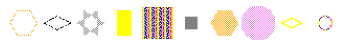

In [12]:
plt.imshow(images[np.random.choice(images.shape[0], 10), ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy())
plt.axis("off")

In [13]:
def fit(model, opt, criterion, scheduler, train_x, train_y, epochs, batch_size,
        model_file, trainer, n_train_samples=None):
    epoch_loss_train = []

    if n_train_samples is None:
        n_train_samples = train_x.shape[0]

    t = trange(epochs)
    for _ in t:
        rnd_idx = list(range(n_train_samples))
        np.random.shuffle(rnd_idx)
        losses = []
        for batch_idx in range(0, n_train_samples, batch_size):   
            model.train()
            opt.zero_grad()
            loss = trainer(model, train_x, train_y, rnd_idx[batch_idx:(batch_idx + batch_size)], criterion)
            loss.backward()
            losses.append(loss.item())
            opt.step()

        epoch_loss_train.append(np.mean(losses))
        scheduler.step()

        t.set_description(f"train: {epoch_loss_train[-1]:.3f}")

    torch.save(model.state_dict(), model_file)
    model.eval()
    return model, epoch_loss_train

In [14]:
vae = DiscreteVAE(
    image_size = images.shape[2],
    num_layers = 3,          # number of downsamples - ex. (32 / (2 ** 3), 32 / (2 ** 3)) = (4 x 4 feature map) 
    num_tokens = 256,        # number of visual tokens. in the paper, they used 8192, but could be smaller for downsized projects
    codebook_dim = 512,      # codebook dimension
    hidden_dim = 64,         # hidden dimension
    num_resnet_blocks = 2,   # number of resnet blocks
    temperature = 0.9,       # gumbel softmax temperature, the lower this is, the harder the discretization
    straight_through = False # straight-through for gumbel softmax. unclear if it is better one way or the other
).to(device)

opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.99)

In [15]:
def train_vae_batch(vae, images, _, idx, __):
    loss = vae(images[idx, ...], return_loss = True)
    return loss

In [16]:
vae_model_file = "data/rainbow_vae.model"
if not os.path.exists(vae_model_file):
    vae, loss_history = fit(vae, opt, None, scheduler, images, None, 500, 128, vae_model_file, train_vae_batch)
    plt.plot(loss_history)
else:
    vae.load_state_dict(torch.load(vae_model_file))

In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Fri Jul 29 16:53:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P0    26W /  N/A |   1109MiB /  8192MiB |     11%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [18]:
with torch.no_grad():
    all_image_codes = vae.get_codebook_indices(images)
    all_images_decoded = vae.decode(all_image_codes)
    
all_image_codes[np.random.choice(images.shape[0], 10), ...]

tensor([[168, 168,  94, 168, 168, 195, 152,  94,  94, 195, 134,  94, 168,  94,
         168, 168],
        [168,  49,  49, 168, 188, 159, 159, 159, 188, 135, 135,  94, 168, 188,
          94, 168],
        [ 90, 123, 123,  62, 219, 219, 219, 123, 219, 219, 219, 170, 152, 219,
         219, 152],
        [168,  94,  94, 168, 168, 195, 159,  94,  94,  44, 134, 168, 168,  94,
         168, 168],
        [168, 168,  94, 168, 168,  50,  50, 168, 168,  50,  24, 168, 168,  94,
         168,  94],
        [ 94, 135, 101, 114, 135,  94,  94, 101, 159, 114,  94, 159,  94, 135,
         101,  94],
        [ 94,  82,  82, 114,  94, 214, 163,  94,  94, 214, 163,  94,  94,  82,
         152,  94],
        [168,  94,  94,  94, 168, 219, 123, 168, 168, 219, 219, 168,  94,  94,
         168, 168],
        [ 94,  94,  94,  49, 247, 152, 188, 217,  94, 247, 101,  94, 168, 114,
         163, 168],
        [168,  49, 170, 168,  94, 224,  49, 188,  94, 170, 159,  94, 168, 114,
         170, 168]], device='c

### 무작위 생성 결과
상단: 원본 그림

하단: VAE가 생성한 그림

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

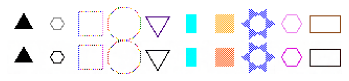

In [19]:
idx = np.random.choice(images.shape[0], 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = all_images_decoded[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

### 가장 나쁜 생성결과

가장 나쁜 생성 결과만 띄웠음에도 원본 이미지와 상당히 비슷한 것을 확인할 수 있습니다. 즉, VAE 학습이 잘 되었다는 의미입니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


big filled black square rotated twice; big filled black square; big filled black square rotated counterclockwise; big filled black square rotated clockwise; big filled black circle; big filled black circle rotated clockwise; big filled black circle rotated counterclockwise; big filled black circle rotated twice; big filled green square; big filled green square rotated clockwise


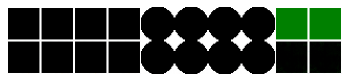

In [20]:
diffs = (images - all_images_decoded).abs().sum(axis=(1, 2, 3)).cpu().numpy()
most_different = np.argsort(-diffs)
idx = most_different[:10]
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = all_images_decoded[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")
print("; ".join(' '.join(captions[i]) for i in idx))

# Training DALL-E

앞서 예고한대로, 데이터에서 30%만 샘플링하여 학습하고 나머지 70% 는 테스트 용으로 사용합니다.

In [21]:
print(captions[:10])

[['bigger', 'black', 'circle'], ['bigger', 'black', 'circle', 'rotated', 'clockwise'], ['bigger', 'black', 'circle', 'rotated', 'counterclockwise'], ['bigger', 'black', 'circle', 'rotated', 'twice'], ['bigger', 'black', 'crescent'], ['bigger', 'black', 'crescent', 'rotated', 'clockwise'], ['bigger', 'black', 'crescent', 'rotated', 'counterclockwise'], ['bigger', 'black', 'crescent', 'rotated', 'twice'], ['bigger', 'black', 'hexagon'], ['bigger', 'black', 'hexagon', 'rotated', 'clockwise']]


In [22]:
import itertools

all_words = list(sorted(frozenset(list(itertools.chain.from_iterable(captions)))))
word_tokens = dict(zip(all_words, range(1, len(all_words) + 1)))
caption_tokens = [[word_tokens[w] for w in c] for c in captions]

In [23]:
caption_tokens[-1]

[24, 31, 28, 21, 29]

In [24]:
longest_caption = max(len(c) for c in captions)
captions_array = np.zeros((len(caption_tokens), longest_caption), dtype=np.int64)

# PyTorch 모델의 입력으로 사용하기 위해서는 모든 입력의 문장 길이가 같아야 합니다.

for cid, tokens in enumerate(caption_tokens):
    captions_array[cid, :len(tokens)] = tokens

captions_array = torch.from_numpy(captions_array).to(device)
captions_mask = captions_array != 0

In [25]:
dalle = DALLE(
    dim = 1024,
    vae = vae,                  # automatically infer (1) image sequence length and (2) number of image tokens
    num_text_tokens = len(word_tokens) + 1,    # vocab size for text
    text_seq_len = longest_caption,         # text sequence length
    depth = 12,                 # should aim to be 64
    heads = 16,                 # attention heads
    dim_head = 64,              # attention head dimension
    attn_dropout = 0.1,         # attention dropout
    ff_dropout = 0.1            # feedforward dropout
).to(device)

opt = torch.optim.Adam(dalle.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

In [26]:
def train_dalle_batch(vae, train_data, _, idx, __):
    text, image_codes, mask = train_data
    loss = dalle(text[idx, ...], image_codes[idx, ...], return_loss=True)
    return loss

In [27]:
np.random.seed(1)
train_fraction = 0.3
train_idx = np.random.choice(len(captions), int(len(captions) * train_fraction))

In [28]:
dalle_model_file = "data/rainbow_dalle.model"
if not os.path.exists(dalle_model_file):
    dalle, loss_history = fit(dalle, opt, None, scheduler, 
                              (captions_array[train_idx, ...], all_image_codes[train_idx, ...], captions_mask[train_idx, ...]), None, 200, 256, 
                              dalle_model_file, train_dalle_batch, 
                              n_train_samples=len(train_idx))

    plt.plot(loss_history)
else:
    dalle.load_state_dict(torch.load(dalle_model_file))

In [29]:
generated_images = []
with torch.no_grad():
    for i in trange(0, len(captions), 128):
        generated = dalle.generate_images(captions_array[i:i + 128, ...], temperature=0.00001)
        generated_images.append(generated)

  0%|          | 0/72 [00:00<?, ?it/s]

In [30]:
generated_images = torch.cat(generated_images, axis=0).cpu().numpy()

### 학습 세트 (Training Set)에 있는 텍스트로 부터 그림 생성
상단: 원본 이미지

하단: DALL-E가 생성한 그림 (참고: DALL-E 는 VQ 워드만 생성하고 실제 픽셀은 VAE가 복원합니다.):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

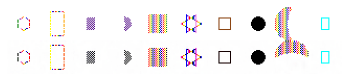

In [31]:
idx = np.random.choice(train_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].transpose(0, 2, 3, 1).reshape(320, 32, 3).transpose(1, 0, 2)
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

### 테스트 세트 (Test Set)에 있는 텍스트로 부터 그림 생성

학습시에 보지 않은 자연어 설명으로 부터 그림을 생성하는 예제입니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

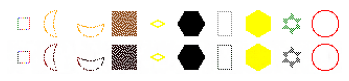

In [32]:
test_idx = np.ones(len(captions), bool)
test_idx[train_idx] = False
test_idx = np.flatnonzero(test_idx)
idx = np.random.choice(test_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].transpose(0, 2, 3, 1).reshape(320, 32, 3).transpose(1, 0, 2)
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

### 테스트 세트 자연어 입력으로부터 VQ 워드를 생성하고, 원본 이미지의 VQ워드와 얼마나 일치하는지 정확도 (Accuracy) 를 측정해봅니다.

In [33]:
from torch.nn import functional as F

def generate_image_code(dalle, text):
    vae, text_seq_len, image_seq_len, num_text_tokens = dalle.vae, dalle.text_seq_len, dalle.image_seq_len, dalle.num_text_tokens
    total_len = text_seq_len + image_seq_len
    out = text

    for cur_len in range(text.shape[1], total_len):
        is_image = cur_len >= text_seq_len

        text, image = out[:, :text_seq_len], out[:, text_seq_len:]

        logits = dalle(text, image)[:, -1, :]
        chosen = torch.argmax(logits, dim=1, keepdim=True)
        chosen -= (num_text_tokens if is_image else 0) # offset sampled token if it is an image token, since logit space is composed of text and then image tokens
        out = torch.cat((out, chosen), dim=-1)

    img_seq = out[:, -image_seq_len:]
    return img_seq

In [34]:
generated_image_codes = []
with torch.no_grad():
    for i in trange(0, len(captions), 128):
        generated = generate_image_code(dalle, captions_array[i:i + 128, ...])
        generated_image_codes.append(generated)
        
generated_image_codes = torch.cat(generated_image_codes, axis=0).cpu()

  0%|          | 0/72 [00:00<?, ?it/s]

In [35]:
# prevent OOM error and commence inference on CPU
torch.cuda.empty_cache()
vae.cpu()

DiscreteVAE(
  (codebook): Embedding(256, 512)
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (4): ResBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
  

In [36]:
with torch.no_grad():
    generated_images = vae.decode(generated_image_codes)

모든 워드가 완전히 일치하는 정확도는 학습세트에서 1.0 (100% 정확도) 을 달성합니다.
### 반면 테스트 세트에서는 약 0.3 정도입니다.

그러나 이는 모든 워드를 전부 맞추는 경우를 측정한 것이고, 각각의 워드를 개별적으로 조사하면 약 0.8 (80% 정확도) 이상의 성능을 보여줍니다.

Train accuracy: 0.69, test accuracy: 0.66


Text(0.5, 0, 'position of image token')

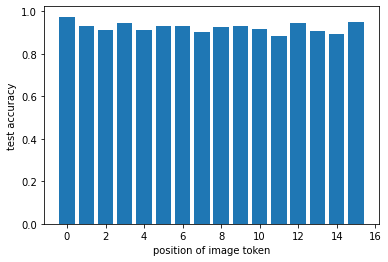

In [37]:
wrong_image_codes = (all_image_codes.cpu() != generated_image_codes).sum(axis=1) != 0
print(f"Train accuracy: {1 - wrong_image_codes[train_idx].sum().item() / len(train_idx):.2f}, "
      f"test accuracy: {1 - wrong_image_codes[test_idx].sum().item() / len(test_idx):.2f}")

accuracy_by_position = 1 - ((all_image_codes.cpu() != generated_image_codes).sum(axis=0) / len(test_idx)).cpu().numpy()
plt.bar(range(len(accuracy_by_position)), accuracy_by_position)
plt.ylabel("test accuracy")
plt.xlabel("position of image token")

### 잘못된 생성 예시

원본 이미지와 다소 다르게 생성한 이미지일지라도 겉보기에 상당히 유사한 이미지가 생성되는 것을 확인할 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

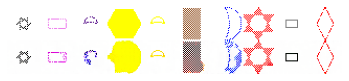

In [38]:
wrong_idx = np.flatnonzero((wrong_image_codes).cpu().numpy())
idx = np.random.choice(wrong_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")